In [2]:
import os
import json
from pyserini.search.lucene import LuceneSearcher
import math
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
docs = []
file_path = r"data\finance_jsonl\corpus.jsonl"
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        docs.append(json.loads(line))

print(f"Jumlah dokumen: {len(docs)}")
print("Contoh dokumen pertama:")
print(docs[0])

Jumlah dokumen: 506
Contoh dokumen pertama:
{'id': 'doc1', 'url': 'https://investasi.kontan.co.id/news/batas-akhir-penawaran-sr023-kian-dekat-amankan-kupon-595-atau-lirik-saham', 'title': 'batas akhir tawar sr023 kian dekat aman kupon 5 95 lirik saham', 'date': '2025-09-12', 'contents': 'dasar data salah satu mitra distribusi sr023 bibit per jumat 12 9 pagi sr023 tenor tiga tahun imbal hasil 5 80 per tahun baru jual paruh 58 3 kuota nasional besar rp 15 triliun jual rp 8 74 triliun sr023 tenor lima tahun imbal hasil 5 95 jual 84 9 kuota nasional rp 5 triliun jual rp 4 24 triliun nilai tenor tiga tahun lebih banyak pilih investor kuota tetap lebih banyak tenor sebut serap hingga jelang tutup tawar maksimal fixed income analyst pefindo ahmad nasrudin kata imbal hasil benar kupon tawar sr023 tenor tiga tahun besar 5 8 tenor lima tahun besar 5 98 lebih tinggi yield pasar yield pasar 5 52 tenor tiga tahun 5 77 tenor lima tahun per kamis 11 9 jadi komparatif kupon sr023 relatif lebih tinggi 

In [4]:
output_path = r"evaluation\ground_truth.json"

In [5]:
ground_truth = [
    {"ekspansi RS MIKA di Sidoarjo kapasitas 200, alokasi belanja modal Rp1T, layanan theranostic": ["doc61", "doc63", "doc69"]},
    {"respon pemerintah dan otoritas pasar modal terhadap instabilitas politik": ["doc372", "doc502", "doc439", "doc444", "doc460", "doc397", "doc452", "doc464", "doc489", "doc264"]},
    {"proyeksi target harga emiten kelapa sawit Indonesia": ["doc310", "doc311", "doc429", "doc29", "doc32", "doc147", "doc297", "doc316", "doc327", "doc348"]},
    {"pergerakan indeks harga saham gabungan IHSG": ["doc6", "doc29", "doc89", "doc145", "doc213", "doc215", "doc252", "doc260", "doc286", "doc430"]}
]


with open(output_path, "w", encoding="utf-8") as f:
    json.dump(ground_truth, f, indent=2, ensure_ascii=False)

print("✅ Ground truth disimpan di:", output_path)

✅ Ground truth disimpan di: evaluation\ground_truth.json


In [6]:
# Lokasi index hasil indexing
index_dir = r"indexes\idx_contents"
searcher = LuceneSearcher(index_dir)

# Baca ground truth
with open(output_path, "r", encoding="utf-8") as f:
    ground_truth = json.load(f)

# Fungsi search
def search(query, k=10):
    hits = searcher.search(query, k=k)
    return [searcher.doc(h.docid).get("id") for h in hits if searcher.doc(h.docid)]

# Jalankan semua query
search_results = {}
for gt_item in ground_truth:
    query = list(gt_item.keys())[0] # Extract the single key which is the query
    result_ids = search(query, k=10)
    search_results[query] = result_ids
    print(f"🔍 {query}\n→ {result_ids}\n")

# Simpan hasil pencarian
with open("evaluation/search_results.json", "w", encoding="utf-8") as f:
    json.dump(search_results, f, indent=2, ensure_ascii=False)

print("✅ Hasil pencarian disimpan di evaluation/search_result.json")

🔍 ekspansi RS MIKA di Sidoarjo kapasitas 200, alokasi belanja modal Rp1T, layanan theranostic
→ ['doc61', 'doc69', 'doc63', 'doc243', 'doc433', 'doc478', 'doc23', 'doc398', 'doc172', 'doc383']

🔍 respon pemerintah dan otoritas pasar modal terhadap instabilitas politik
→ ['doc372', 'doc460', 'doc29', 'doc241', 'doc174', 'doc502', 'doc230', 'doc303', 'doc276', 'doc209']

🔍 proyeksi target harga emiten kelapa sawit Indonesia
→ ['doc311', 'doc310', 'doc141', 'doc198', 'doc429', 'doc329', 'doc334', 'doc29', 'doc327', 'doc348']

🔍 pergerakan indeks harga saham gabungan IHSG
→ ['doc444', 'doc29', 'doc293', 'doc109', 'doc397', 'doc439', 'doc88', 'doc464', 'doc403', 'doc429']

✅ Hasil pencarian disimpan di evaluation/search_result.json


In [7]:
def safe_div(a, b):
    return a / b if b else 0.0

def evaluate_query(query, retrieved, relevant):
    k_values = [1, 3, 5, 10]
    precision_at_k, recall_at_k, f1_at_k = {}, {}, {}

    relevant_found = 0
    ap_sum = 0.0
    total_relevant = len(relevant)

    for i, doc_id in enumerate(retrieved, 1):
        if doc_id in relevant:
            relevant_found += 1
            ap_sum += relevant_found / i

        for k in k_values:
            if i == k:
                p = safe_div(relevant_found, k)
                r = safe_div(relevant_found, total_relevant)
                precision_at_k[k] = p
                recall_at_k[k] = r
                f1_at_k[k] = safe_div(2 * p * r, p + r) if p + r > 0 else 0.0

    ap = safe_div(ap_sum, total_relevant)
    recall_overall = safe_div(relevant_found, total_relevant)
    return precision_at_k, recall_at_k, f1_at_k, ap, recall_overall

with open("evaluation/search_results.json", "r", encoding="utf-8") as f:
    search_results = json.load(f)

total_ap = 0
reciprocal_ranks = [] # Initialize list to store reciprocal ranks

for gt_item in ground_truth:
    query = list(gt_item.keys())[0]
    relevant_docs = gt_item[query]
    retrieved_docs = search_results.get(query, [])

    p_at_k, r_at_k, f1_at_k, ap, recall_total = evaluate_query(query, retrieved_docs, relevant_docs)
    total_ap += ap

    # Calculate reciprocal rank for MRR
    rank = 0
    if relevant_docs:
        for i, doc_id in enumerate(retrieved_docs):
            if doc_id in relevant_docs:
                rank = i + 1
                break
        if rank > 0:
            reciprocal_ranks.append(1 / rank)
        elif relevant_docs:
             reciprocal_ranks.append(0)


    print(f"\n=== Evaluasi Query: {query} ===")
    print(f"Average Precision (AP): {ap:.4f}")
    for k in [1, 3, 5, 10]:
        print(f"P@{k}: {p_at_k.get(k,0):.4f} | R@{k}: {r_at_k.get(k,0):.4f} | F1@{k}: {f1_at_k.get(k,0):.4f}")
    print(f"Total Recall: {recall_total:.4f}")

map_score = safe_div(total_ap, len(ground_truth))
print("\n📊 Mean Average Precision (MAP):", round(map_score, 4))

# Calculate and print MRR
mrr_score = safe_div(sum(reciprocal_ranks), len(ground_truth))
print("📊 Mean Reciprocal Rank (MRR):", round(mrr_score, 4))


=== Evaluasi Query: ekspansi RS MIKA di Sidoarjo kapasitas 200, alokasi belanja modal Rp1T, layanan theranostic ===
Average Precision (AP): 1.0000
P@1: 1.0000 | R@1: 0.3333 | F1@1: 0.5000
P@3: 1.0000 | R@3: 1.0000 | F1@3: 1.0000
P@5: 0.6000 | R@5: 1.0000 | F1@5: 0.7500
P@10: 0.3000 | R@10: 1.0000 | F1@10: 0.4615
Total Recall: 1.0000

=== Evaluasi Query: respon pemerintah dan otoritas pasar modal terhadap instabilitas politik ===
Average Precision (AP): 0.2500
P@1: 1.0000 | R@1: 0.1000 | F1@1: 0.1818
P@3: 0.6667 | R@3: 0.2000 | F1@3: 0.3077
P@5: 0.4000 | R@5: 0.2000 | F1@5: 0.2667
P@10: 0.3000 | R@10: 0.3000 | F1@10: 0.3000
Total Recall: 0.3000

=== Evaluasi Query: proyeksi target harga emiten kelapa sawit Indonesia ===
Average Precision (AP): 0.4256
P@1: 1.0000 | R@1: 0.1000 | F1@1: 0.1818
P@3: 0.6667 | R@3: 0.2000 | F1@3: 0.3077
P@5: 0.6000 | R@5: 0.3000 | F1@5: 0.4000
P@10: 0.6000 | R@10: 0.6000 | F1@10: 0.6000
Total Recall: 0.6000

=== Evaluasi Query: pergerakan indeks harga saham 


=== HASIL EVALUASI PER QUERY ===
                                               Query  P@1       P@3  P@5  \
0  ekspansi RS MIKA di Sidoarjo kapasitas 200, al...  1.0  1.000000  0.6   
1  respon pemerintah dan otoritas pasar modal ter...  1.0  0.666667  0.4   
2  proyeksi target harga emiten kelapa sawit Indo...  1.0  0.666667  0.6   
3        pergerakan indeks harga saham gabungan IHSG  0.0  0.333333  0.2   

   P@10  R@10     F1@10        AP   nDCG@10  
0   0.3   1.0  0.461538  1.000000  2.457269  
1   0.3   0.3  0.300000  0.250000  0.687436  
2   0.6   0.6  0.600000  0.425556  1.011310  
3   0.1   0.1  0.100000  0.050000  0.218266  

=== HASIL AKHIR (TABEL) ===
                                               Query   P@1       P@3   P@5  \
0  ekspansi RS MIKA di Sidoarjo kapasitas 200, al...  1.00  1.000000  0.60   
1  respon pemerintah dan otoritas pasar modal ter...  1.00  0.666667  0.40   
2  proyeksi target harga emiten kelapa sawit Indo...  1.00  0.666667  0.60   
3        perge

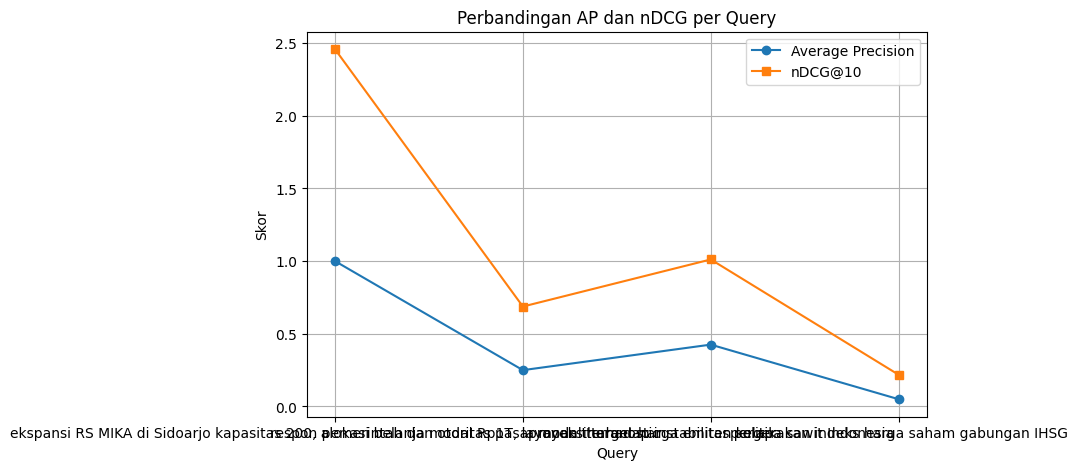

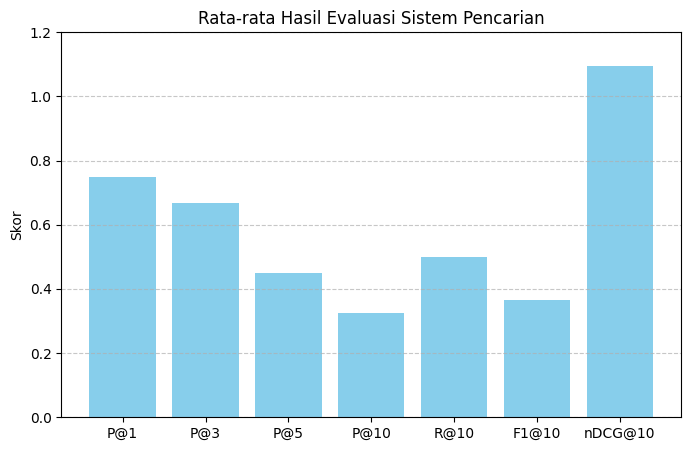

In [9]:
def safe_div(a, b):
    return a / b if b else 0.0

def ndcg_score(retrieved, relevant, k=10):
  dcg = 0.0
  for i, doc_id in enumerate(retrieved[:k], 1):
    rel_i = 1 if doc_id in relevant else 0
    dcg += safe_div(rel_i, math.log2(i + 1))
  ideal_rel = [1] * min(len(relevant), k)
  idcg = sum(safe_div(rel, math.log2(i + 1)) for ir, rel in enumerate(ideal_rel, 1))
  return safe_div(dcg, idcg)

def evaluate_query(query, retrieved, relevant):
    k_values = [1, 3, 5, 10]
    precision_at_k, recall_at_k, f1_at_k = {}, {}, {}

    relevant_found = 0
    ap_sum = 0.0
    total_relevant = len(relevant)

    for i, doc_id in enumerate(retrieved, 1):
        if doc_id in relevant:
            relevant_found += 1
            ap_sum += relevant_found / i

        for k in k_values:
            if i == k:
                p = safe_div(relevant_found, k)
                r = safe_div(relevant_found, total_relevant)
                precision_at_k[k] = p
                recall_at_k[k] = r
                f1_at_k[k] = safe_div(2 * p * r, p + r) if p + r > 0 else 0.0

    ap = safe_div(ap_sum, total_relevant)
    recall_overall = safe_div(relevant_found, total_relevant)
    ndcg_val = ndcg_score(retrieved, relevant, 10)
    return precision_at_k, recall_at_k, f1_at_k, ap, recall_overall, ndcg_val

with open("evaluation\search_results.json", "r", encoding="utf-8") as f:
    search_results = json.load(f)

total_ap = 0
reciprocal_ranks = [] # Initialize list to store reciprocal ranks
results = []

for gt_item in ground_truth:
    query = list(gt_item.keys())[0]
    relevant_docs = gt_item[query]
    retrieved_docs = search_results.get(query, [])

    p_at_k, r_at_k, f1_at_k, ap, recall_total, ndcg_val = evaluate_query(query, retrieved_docs, relevant_docs)
    total_ap += ap

    rank = 0
    if relevant_docs:
        for i, doc_id in enumerate(retrieved_docs):
            if doc_id in relevant_docs:
                rank = i + 1
                break
        reciprocal_ranks.append(1 / rank if rank > 0 else 0)
    else:
        reciprocal_ranks.append(0)

    results.append({
        "Query": query,
        "P@1": p_at_k.get(1, 0),
        "P@3": p_at_k.get(3, 0),
        "P@5": p_at_k.get(5, 0),
        "P@10": p_at_k.get(10, 0),
        "R@10": r_at_k.get(10, 0),
        "F1@10": f1_at_k.get(10, 0),
        "AP": ap,
        "nDCG@10": ndcg_val
    })

# Hitung MAP dan MRR
map_score = safe_div(total_ap, len(ground_truth))
mrr_score = safe_div(sum(reciprocal_ranks), len(ground_truth))

# Tampilkan hasil dalam tabel
df_results = pd.DataFrame(results)
print("\n=== HASIL EVALUASI PER QUERY ===")
print(df_results)

# Tambahkan rata-rata ke tabel
summary_row = {
    "Query": "Rata-rata",
    "P@1": df_results["P@1"].mean(),
    "P@3": df_results["P@3"].mean(),
    "P@5": df_results["P@5"].mean(),
    "P@10": df_results["P@10"].mean(),
    "R@10": df_results["R@10"].mean(),
    "F1@10": df_results["F1@10"].mean(),
    "AP": map_score,
    "nDCG@10": df_results["nDCG@10"].mean()
}
df_results = pd.concat([df_results, pd.DataFrame([summary_row])], ignore_index=True)

print("\n=== HASIL AKHIR (TABEL) ===")
print(df_results)
print("\nMAP:", round(map_score, 4))
print("MRR:", round(mrr_score, 4))

# Buat grafik evaluasi
plt.figure(figsize=(8, 5))
plt.plot(df_results["Query"][:-1], df_results["AP"][:-1], marker='o', label="Average Precision")
plt.plot(df_results["Query"][:-1], df_results["nDCG@10"][:-1], marker='s', label="nDCG@10")
plt.title("Perbandingan AP dan nDCG per Query")
plt.xlabel("Query")
plt.ylabel("Skor")
plt.legend()
plt.grid(True)
plt.show()

# Grafik rata-rata
avg_metrics = {
    "P@1": df_results.loc[df_results["Query"] == "Rata-rata", "P@1"].values[0],
    "P@3": df_results.loc[df_results["Query"] == "Rata-rata", "P@3"].values[0],
    "P@5": df_results.loc[df_results["Query"] == "Rata-rata", "P@5"].values[0],
    "P@10": df_results.loc[df_results["Query"] == "Rata-rata", "P@10"].values[0],
    "R@10": df_results.loc[df_results["Query"] == "Rata-rata", "R@10"].values[0],
    "F1@10": df_results.loc[df_results["Query"] == "Rata-rata", "F1@10"].values[0],
    "nDCG@10": df_results.loc[df_results["Query"] == "Rata-rata", "nDCG@10"].values[0]
}

plt.figure(figsize=(8,5))
plt.bar(avg_metrics.keys(), avg_metrics.values(), color='skyblue')
plt.title("Rata-rata Hasil Evaluasi Sistem Pencarian")
plt.ylabel("Skor")
plt.ylim(0, 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()